# Lab 7: Training Neural Networks

Related lecture: https://ucmercedcse176.github.io/files/lecture_11.pdf

(Credit to [Ben Trevett](https://bentrevett.com/) for some materials.)

## Part I: Batch Normalization

In this part, we will answer three questions on batch normalization. Put your answers in solution sections.

Question 1: How many learnable parameters are there in a batch normalization layer?

Soluton: There are 2 learnable parameters, gamma and beta. The scale parameter is gamma, and the shift parameter is beta.  

Question 2: How to set these parameters, so that batch normalization becomes an identity mapping function for input features X?

Solution: Since it acts like an identity mapping function, you set gamma to 1 and beta to 0. This prevents any scaling or shifting of the normalized input.

Question 3: Will using batch normalization layer lead to different results with the same data (same X) for training and testing? Explain your answer in a few sentences.

Solution: Yes, if you use batch normalized layer the results will be different between training and testing. This is because, in training it computes the mean and variance of X over each batch. And in testing, it uses the global running estimates of accumulated during training. So overall, the results will vary in both phases due to different statistics/values used.

## Part II: Optimization for Neural Network
In this part, we will implement three optimization methods discussed in class including **SGD**, **SGD with momentum**, and **AdaGrad**. We will compare these methods on MNIST classification. MNIST is made up of hand drawn digits, from 0-9, represented by 28×28 pixel black-and-white images.

Compelete missing code.

In [1]:
# packages needed
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

## Dataset and Model

We'll normalize the images using a pre-computed mean and standard deviation and perform some data augmentation, namely: randomly rotating and cropping the images.

In [2]:
mean = 0.13066048920154572
std = 0.30810779333114624

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.RandomCrop(28, padding = 2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [mean], std = [std])])

train_data = datasets.MNIST(root = '.data',
                            train = True,
                            download = True,
                            transform = train_transforms)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 625kB/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.46MB/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.63MB/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



We then create the iterator for the data. Note that in practice a larger batch size usually allows you to use a larger learning rate.

In [3]:
batch_size = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = batch_size)

Next, we'll define our architecture: a multi-layer perceptron (MLP) with a single hidden layer.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hid_dim)
        self.layer2 = nn.Linear(hid_dim, hid_dim)
        self.layer3 = nn.Linear(hid_dim, output_dim)
        self.init_params()

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x = [batch size, channels, height, width]
        batch_size, *_ = x.shape
        x = x.view(batch_size, -1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

Our model uses a 256-dimensional hidden layer. Again, this is chosen pretty much arbitrarily and smaller values may work just as well.

In [5]:
input_dim = 28 * 28
hid_dim = 256
output_dim = 10

model = MLP(input_dim, hid_dim, output_dim)

Supervised learning where each example belongs to a single class almost always uses cross-entropy loss.

In [6]:
criterion = nn.CrossEntropyLoss()

We'll then put the `.to` method to put the model and the loss function on to our GPU, if we have one.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

Next up, we'll define some functions for training the model with our optimizers and plotting the results.

`train_epoch` performs a single epoch of training and returns a list of losses per batch.

In [8]:
def train_epoch(iterator, model, optimizer, criterion, device):
    """Performs one epoch of training."""

    losses = []

    for images, labels in tqdm.tqdm(iterator):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

`train` initializes a model and then performs `n_epochs` of training, storing and returning the loss per batch over all the epochs.

In [9]:
def train(train_iterator, model, optimizer, criterion, device, n_epochs=5):
    """Trains the model for the given amount of epochs."""

    losses = []

    model.init_params()

    for epoch in range(n_epochs):
        epoch_losses = train_epoch(train_iterator, model, optimizer, criterion, device)
        losses.extend(epoch_losses)

    return losses

We have two functions for viewing our results.

`plot_loss` is used for plotting the results of a single experiment. `plot_losses` plots the results of multiple experiments, which is used to compare optimizers against each other.

In [10]:
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

In [11]:
def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')

Now let's implement our first optimizer!

## Optimizer 1: Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm, so it's a good place to start. We take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta J(\theta_t)$, multiplied by the "learning rate", $\eta$.


The SGD algorithm is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one parameter, $\theta$, we have multiple parameters: the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

All optimizers need a way of keeping track of the parameters they're supposed to be updating `model_params` and a learning rate, `lr`. SGD in PyTorch doesn't have a default learning rate but `1e-3` is a common default learning rate value for other optimizers, so we use it here. All optimizers need a `zero_grad` function in order to remove the gradients calculated from the last update step, and a `step` function to perform a parameter update.

Note that any PyTorch method with a trailing underscore, e.g., `.sub_`, means the operation is in-place. This means ourour `step` function is updating each `param`, a tensor of parameters, in-place. These in-place operations are usually significantly faster non in-place operations.

In [35]:
class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            param.sub_(self.lr * param.grad) # complete code here. How to update params? you can use inline function .sub_

We can define our optimizer like so:

In [36]:
optimizer = SGD(model.parameters())

Then we use it to train our model for five epochs and get the training loss.

In [37]:
sgd_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:31<00:00, 15.02it/s]


Now let's plot it and see what it looks like.

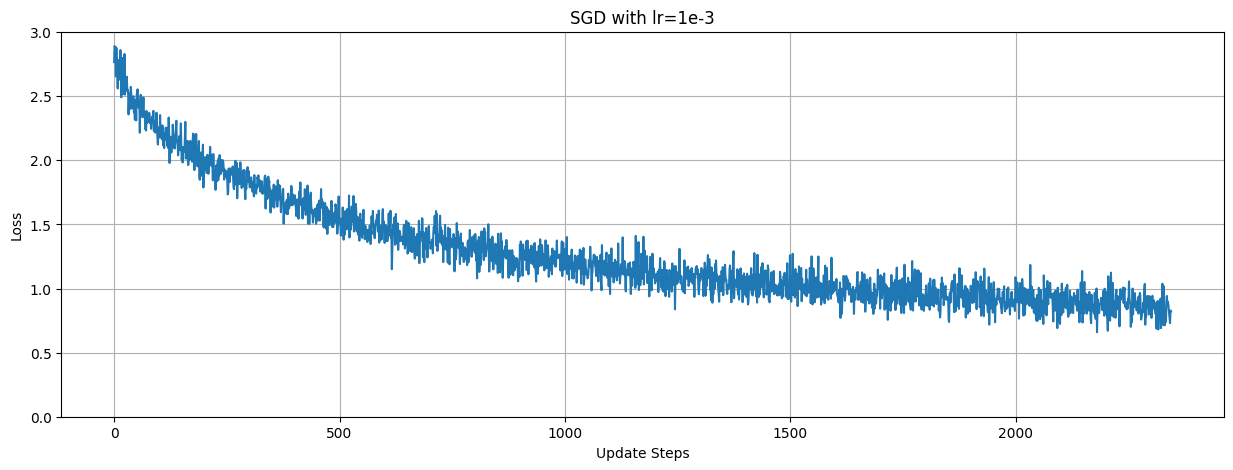

In [38]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')

Looks reasonable, the loss starts at a high value as our parameters are randomly initialized and then proceeds to decrease steadily. We can't really tell how "good" it is without comparing it against another optimizer, so let's go ahead and do that now.

## Optimizer 2: SGD with Momentum

Gradient descent with momentum converges  faster than standard gradient descent. Momentum reduces oscillation in direction with large gradient.

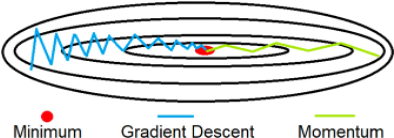

Our parameter update is now calculated using a velocity, $v$, which depends on the previous velocity multiplied by the momentum $\alpha$ minus the current gradient multiplied by the learning rate. We will implement this version in this lab.

\begin{align*}
    v_{t,i} &= \alpha \cdot v_{t-1,i} - \lambda \cdot \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} + v_{t,i}\\
\end{align*}

If momentum $\alpha$ is zero then we don't care about the previous velocity at all and this algorithm becomes SGD. Commonly used momentum values are usually around 0.9ish.

Note that the velocity `v` is a list of tensors corresponding to the model parameters, so we are storing the velocity of every single parameter in our model.


Note that PyTorch's optimizers are a little different from the actual algorithms. PyTorch's version of SGD with momentum moves the learning rate outside the equation for velocity:

\begin{align*}
    v_{t,i} &= \alpha \cdot v_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \lambda \cdot v_{t,i}\\
\end{align*}




In [43]:
class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum
        self.v = [torch.zeros_like(p) for p in self.model_params]

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, v in zip(self.model_params, self.v):
            v.mul_(self.momentum).add_(param.grad) # complete code here. How to update v?
            param.sub_(self.lr * v) # complete code here. How to update param?

Below we define our SGD with momentum optimizer, train our model and plot the results.

In [44]:
optimizer = SGDMomentum(model.parameters())

In [45]:
sgd_momentum_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:31<00:00, 15.11it/s]


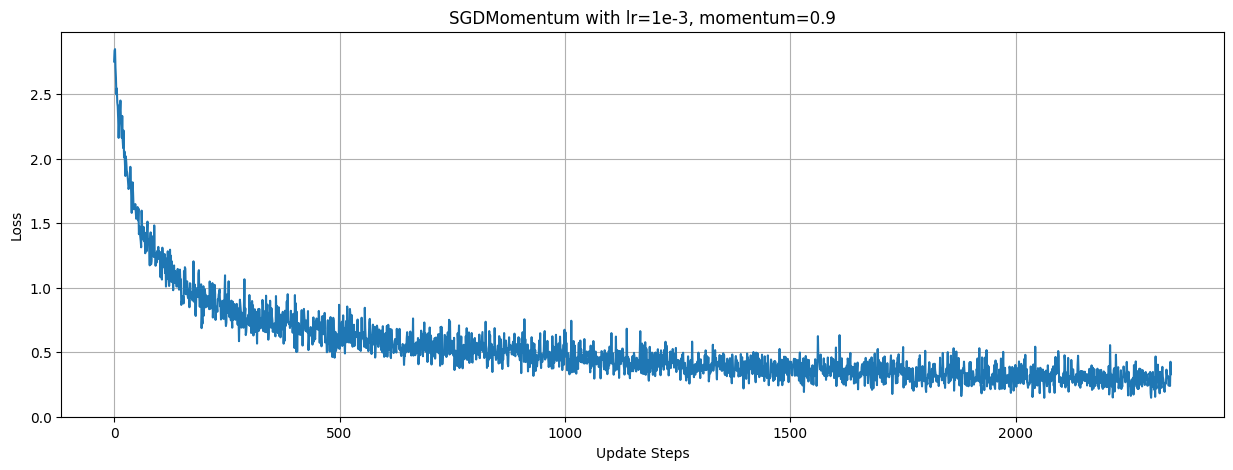

In [46]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3, momentum=0.9')

Now let's compare SGD and SGD with momentum.

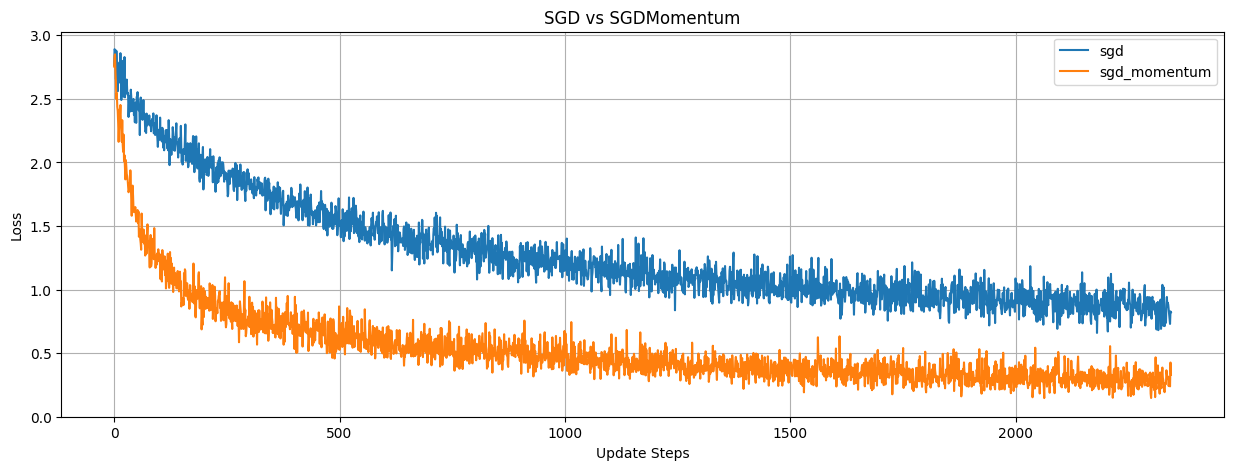

In [47]:
losses = [sgd_loss, sgd_momentum_loss]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')

Let's move on to the next optimizer.

## Optimizer 3: Adagrad

One downside with SGD is that we use a single learning rate across all of our parameters, and that this learning rate is fixed through the entirety of training.

Ideally, parameters that are updated more frequently have a lower learning rate and parameters that are updated infrequently have a larger learning rate.

This is what Adagrad does. We use $r_{t,i}$ which is the sum of the squared gradients for parameter $i$ up to, and including, time-step $t$. $r\_{t,i}$ is initialized to some value, usually zero by default. As the square of the gradients of a parameter are accumulated, $r_{t,i}$ increases, and thus reduces the learning rate for parameter $i$.

$$\theta_{t+1,i} = \theta_{t,i} - \frac{\lambda}{\sqrt{r_{t,i}}+\epsilon} \cdot \nabla_\theta J(\theta_{t,i})$$

where:

$$r_{t,i} = r_{t-1,i} + \Big(\nabla_\theta J(\theta_{t,i})\Big)^2$$

$\epsilon$ is very small number, used to avoid division by zero in the denominator. Sometimes you'll see $\epsilon$ inside the square root, and sometimes it will be outside. PyTorch leaves it outside so we will too.

We implement Adagrad below, initializing $r$ as a list of tensors called `acc_sqr_grads` and using `std` to refer to the denominator of the update step equation.

In [53]:
class Adagrad:
    def __init__(self, model_params, lr=1e-2, init_acc_sqr_grad=0, eps=1e-10):
        self.model_params = list(model_params)
        self.lr = lr
        self.acc_sqr_grads = [torch.full_like(p, init_acc_sqr_grad) for p in self.model_params]
        self.eps = eps

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param, acc_sqr_grad in zip(self.model_params, self.acc_sqr_grads):
            acc_sqr_grad.add_(param.grad ** 2) # complete code here
            std = (acc_sqr_grad).sqrt() + self.eps # complete code here
            param.sub_(self.lr * param.grad / std) # complete code here

In [54]:
optimizer = Adagrad(model.parameters())

In [55]:
adagrad_loss = train(train_iterator, model, optimizer, criterion, device)

100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


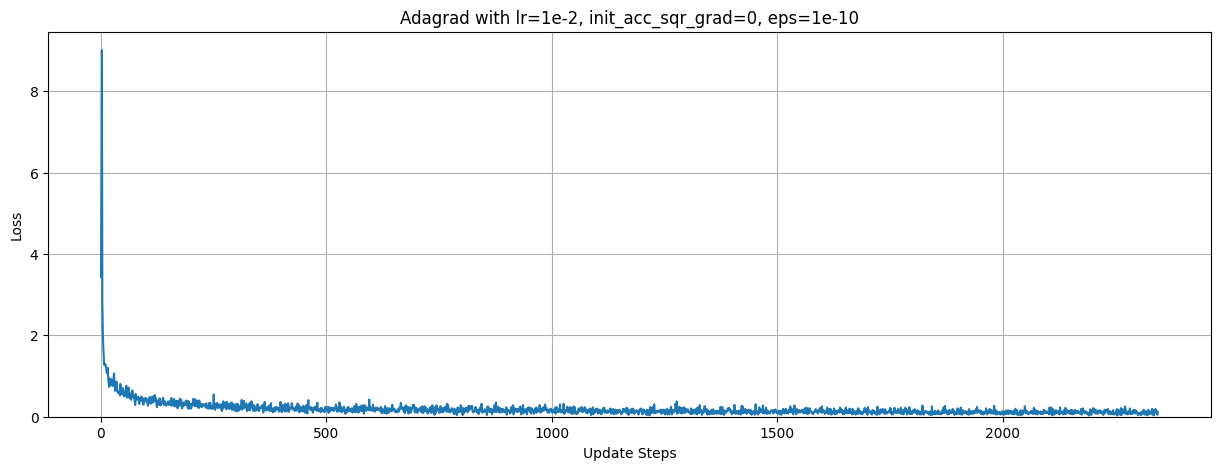

In [56]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10')

We can see there's an initial large spike in the loss value. This is due to the initial $r$ values being very small and thus the learning rate is divided by a very small number making it very large. Very large learning rates usually lead to unstable training which give higher loss values.

Let's trim the start to get a better view what the final loss value is.

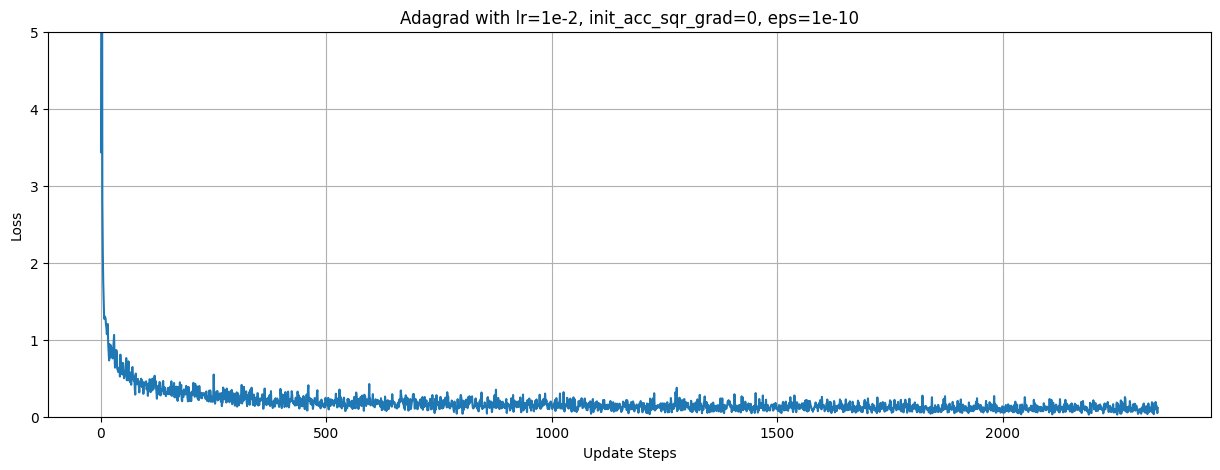

In [57]:
plot_loss(adagrad_loss, 'Adagrad with lr=1e-2, init_acc_sqr_grad=0, eps=1e-10', ymax=5.0)

Let's compare our Adagrad loss to our SGD algorithms.

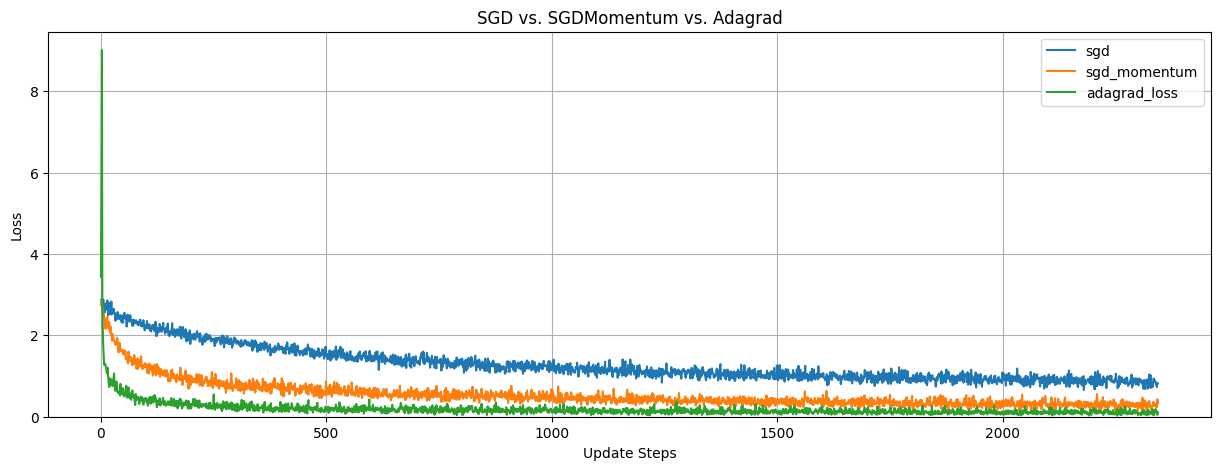

In [58]:
losses = [sgd_loss, sgd_momentum_loss, adagrad_loss]
labels = ['sgd', 'sgd_momentum', 'adagrad_loss']

plot_losses(losses, labels, 'SGD vs. SGDMomentum vs. Adagrad')